In [1]:
import os
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
import string

In [2]:
# forming list of stop_words
import nltk
from nltk.corpus import stopwords
stop_words = list(set(stopwords.words('english')))


In [3]:
def x_y():
    
    f = ["alt.atheism","comp.graphics","comp.os.ms-windows.misc","comp.sys.ibm.pc.hardware","comp.sys.mac.hardware","comp.windows.x","misc.forsale",
    "rec.autos","rec.motorcycles","rec.sport.baseball","rec.sport.hockey","sci.crypt","sci.electronics","sci.med","sci.space","soc.religion.christian",
    "talk.politics.guns","talk.politics.mideast","talk.politics.misc","talk.politics.misc"]
    
    x = []
    y = []
    
    for i in range(20):    
        name_of_folder = f[i]
        path1 = "20_newsgroups/" + name_of_folder    
        file_list = os.listdir(path1)
        for j in file_list:
            path_of_file = path1 + "/" + j
            x.append(path_of_file)
            y.append(name_of_folder)
            
    return x,y
    

In [4]:
x,y = x_y() # x is a 1d array consisting of path of each document, y is a 1d array consisting of corresponding names of folders as class labels

In [9]:
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,random_state = 1) # splitting the initial x and y into train and test

In [10]:
import matplotlib.pyplot as plt

In [11]:
# function to pre process the words before forming the vocabulary

def process(words):
   
    
    p = (string.punctuation).replace("'", "")  + "\t"
    table = str.maketrans('', '', p)
    words = [word.translate(table) for word in words]
    words = [str for str in words if str]
    words = [word for word in words if not word.isdigit()]
    words = [str for str in words if str]
    words = [word.lower() for word in words]
    words = [word for word in words if len(word) > 2]
    
    return words


In [12]:
# function to form the vocabulary

def vocab(x_train):
    
    d = {} 
    for i in range(len(x_train)):
        with open(x_train[i]) as file_obj:
            message = file_obj.read()
            words = message.split()
            words = process(words)
            for word in words:
                if word not in stop_words:
                    d[word] = d.get(word,0) + 1
    words = np.array(list(d.keys()))
    count = np.array(list(d.values()))
    ind = np.argsort(count)
    words = words[ind]
    count = count[ind]
    plt.plot(words[-1:-2001:-1],count[-1:-2001:-1])

    plt.show()
    vocabulary = words[-1:-2001:-1] # taking 2000 words as vocabulary (ie. no. of features)
    return vocabulary,d

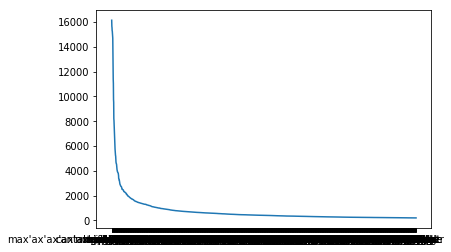

2000

In [13]:
vocabulary,d = vocab(x_train)
len(vocabulary)

In [15]:
# forming a dictionary containing the corresponding indices of the words of the vocabulary
index = {}
for i in range(len(vocabulary)):
    index[vocabulary[i]] = i

In [16]:
# function to convert x into a 2d array 

def x2d(x,vocabulary,index):
    x_2d = [[0 for i in range(len(vocabulary))] for j in range(len(x))]
    for i in range(len(x)):
        with open(x[i]) as file_obj:
            message = file_obj.read()
            words = message.split()
            for word in words:
                if word in vocabulary:
                    j = index[word] 
                    x_2d[i][j] += 1
    return x_2d

In [17]:
x_train_2d = x2d(x_train,vocabulary,index)

## Using inbuilt sklearn Multinomial NB:-

In [18]:
clf = MultinomialNB()
clf.fit(x_train_2d,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
x_test_2d = x2d(x_test,vocabulary,index) # transforming x_test into 2d array

In [20]:
y_pred = clf.predict(x_test_2d)

In [21]:
print(clf.score(x_train_2d,y_train))

0.725078349003134


In [22]:
print(clf.score(x_test_2d,y_test)) 

0.662


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.64      0.70      0.67       261
           comp.graphics       0.50      0.60      0.54       248
 comp.os.ms-windows.misc       0.48      0.53      0.51       253
comp.sys.ibm.pc.hardware       0.58      0.52      0.55       260
   comp.sys.mac.hardware       0.58      0.53      0.55       266
          comp.windows.x       0.70      0.59      0.64       265
            misc.forsale       0.70      0.74      0.72       252
               rec.autos       0.65      0.70      0.67       223
         rec.motorcycles       0.73      0.72      0.73       293
      rec.sport.baseball       0.70      0.75      0.72       245
        rec.sport.hockey       0.82      0.74      0.78       247
               sci.crypt       0.86      0.78      0.82       248
         sci.electronics       0.59      0.63      0.61       239
                 sci.med       0.78      0.75      0.76       236
         

## Self Implementation of Multinomial Naive Bayes:-

In [24]:
# fit function to form and return a count dictionary 

def fit(X_train,Y_train,vocabulary):
    
    Y_train = np.array(Y_train)
    X_train = np.array(X_train)
    
    count = {} # main dictionary
    classes = set(Y_train)
    for current_class in classes:
        count[current_class] = {}
        current_class_rows = (Y_train == current_class) # getting all current_class_rows
        X_train_current = X_train[current_class_rows]
        count[current_class]["total_words"] = sum(sum(X_train_current)) # total number of words in all documents of current_class
        for i in range(len(vocabulary)):
            count[current_class][vocabulary[i]] = X_train_current[:,i].sum()
            
    return count

In [31]:
# probability function to return prob(wi/y=ci) in logarthimic form

def prob(word,count,current_class):
    
    ans = np.log(count[current_class][word]+1) - np.log(count[current_class]["total_words"]+len(vocabulary)) # along with laplace correctiion
    return ans
    
# predict function to predict the class values for given x_test

def predict(x_test,count,vocabulary):
    
    y_pred = []
    
    for i in range(len(x_test)):
        with open(x_test[i]) as document:
            w = []
            message = document.read()
            words = message.split()
            classes = set(y)
            
            for word in words:
                if word in vocabulary:
                    w.append(word)
                    
            max_probability = -1000
            best_class = -1
        
            for current_class in classes:
                
                pr = np.log(1/20) # probabilty of y=current_class
                for wo in w:
                    p = prob(wo,count,current_class)
                    pr  += p # adding all logarithmic probabilities
                    
                if pr > max_probability:
                    max_probability = pr 
                    best_class = current_class
                
            y_pred.append(best_class)
        
    return y_pred

In [26]:
count = fit(x_train_2d,y_train,vocabulary)

In [27]:
count

{'talk.politics.mideast': {'total_words': 65177,
  'subject': 41,
  'lines': 15,
  'date': 12,
  'newsgroups': 3,
  'path': 5,
  'messageid': 0,
  'organization': 26,
  'apr': 0,
  'gmt': 0,
  'would': 862,
  'one': 831,
  'writes': 32,
  'references': 16,
  'article': 673,
  'sender': 0,
  'people': 857,
  'like': 484,
  'university': 4,
  'know': 443,
  'get': 313,
  'nntppostinghost': 0,
  'think': 353,
  'also': 383,
  'may': 191,
  'new': 121,
  'use': 104,
  'time': 255,
  "i'm": 1,
  'could': 374,
  'xref': 0,
  'cantaloupesrvcscmuedu': 0,
  'good': 118,
  'system': 40,
  'even': 408,
  'well': 146,
  'see': 308,
  'make': 225,
  'much': 165,
  'way': 224,
  'first': 298,
  'many': 408,
  'news': 64,
  'two': 331,
  'right': 311,
  'say': 273,
  'distribution': 2,
  'want': 222,
  'said': 468,
  'world': 309,
  'used': 128,
  'anyone': 88,
  'need': 116,
  'work': 200,
  'really': 165,
  'something': 170,
  'government': 256,
  'since': 156,
  'problem': 84,
  'please': 51,
  'g

In [28]:
y_pred = predict(x_test,count,vocabulary) # here we are using the normal x_test containing path of all test documents instead of the 2d array

In [29]:
y_pred

['talk.politics.guns',
 'rec.motorcycles',
 'rec.motorcycles',
 'soc.religion.christian',
 'comp.graphics',
 'soc.religion.christian',
 'rec.sport.hockey',
 'misc.forsale',
 'sci.space',
 'rec.autos',
 'talk.politics.misc',
 'misc.forsale',
 'comp.os.ms-windows.misc',
 'talk.politics.mideast',
 'rec.sport.baseball',
 'sci.crypt',
 'sci.electronics',
 'rec.motorcycles',
 'rec.autos',
 'alt.atheism',
 'comp.sys.mac.hardware',
 'talk.politics.guns',
 'alt.atheism',
 'rec.sport.baseball',
 'comp.os.ms-windows.misc',
 'sci.space',
 'comp.sys.ibm.pc.hardware',
 'alt.atheism',
 'sci.crypt',
 -1,
 'comp.os.ms-windows.misc',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'misc.forsale',
 'soc.religion.christian',
 'sci.med',
 'comp.os.ms-windows.misc',
 'rec.motorcycles',
 'comp.sys.ibm.pc.hardware',
 'soc.religion.christian',
 'sci.electronics',
 'talk.politics.misc',
 -1,
 'talk.politics.misc',
 'talk.politics.misc',
 'sci.crypt',
 'comp.os.ms-windows.misc',
 'alt.atheism',
 'sci.c

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                          precision    recall  f1-score   support

                      -1       0.00      0.00      0.00         0
             alt.atheism       0.62      0.64      0.63       261
           comp.graphics       0.49      0.56      0.52       248
 comp.os.ms-windows.misc       0.48      0.52      0.50       253
comp.sys.ibm.pc.hardware       0.57      0.50      0.53       260
   comp.sys.mac.hardware       0.57      0.53      0.55       266
          comp.windows.x       0.70      0.57      0.63       265
            misc.forsale       0.70      0.73      0.71       252
               rec.autos       0.63      0.66      0.65       223
         rec.motorcycles       0.71      0.72      0.71       293
      rec.sport.baseball       0.68      0.73      0.71       245
        rec.sport.hockey       0.81      0.70      0.75       247
               sci.crypt       0.85      0.73      0.79       248
         sci.electronics       0.58      0.61      0.60       239
         

C:\Users\noaim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
